In [40]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
import pathlib
from types import FunctionType
from PIL import Image, ImageColor, ImageDraw, ImageFont
import tqdm
# from torchinfo import summary
import abc  # Abstract base class
import numpy as np

In [41]:
#@title Hyperparameters

T = 1000 # Timesteps

In [42]:
#@title Device / CUDA

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f'Using device: {device}')

Using device: cuda


In [43]:
@dataclass
class DataPack:
    train_dataset: Dataset
    train_loader: DataLoader
    val_dataset: Dataset
    val_loader: DataLoader
    transform_to_tensor: Any
    transform_to_pil: Any
    in_channels: int
    out_channels: int
    num_classes: int
    recommended_steps: Tuple[int]
    recommended_attn_step_indexes: List[int]

class MNISTTransformation:
    def __call__(self, tensor: torch.Tensor):
        return (tensor * -1 + 1).permute(1,2,0).detach().cpu().numpy()

def get_mnist_loader_and_transform(
    path_to_dataset: str = "../../datasets",
    batch_size: int = 128,
    num_workers: int = 2
) -> DataPack:
    transform = transforms.Compose([
        transforms.Resize((32, 32)),        # Ensure input size matches UNet2DModel
        transforms.ToTensor()
    ])
    train_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.MNIST(root=path_to_dataset, download=True, transform=transform, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return DataPack(
        train_dataset=train_dataset,
        train_loader=train_dataloader,
        val_dataset=val_dataset,
        val_loader=val_dataloader,
        transform_to_tensor=transform,
        transform_to_pil=MNISTTransformation(),
        in_channels=1,
        out_channels=1,
        num_classes=10,
        recommended_steps=(1,2,4),
        recommended_attn_step_indexes=[1]
    )

class CifarTransformation:
    def __call__(self, tensor: torch.Tensor):
        return (tensor * 127.5 + 127.5).long().clip(0,255).permute(1,2,0).detach().cpu().numpy()

def get_cifar10_loader_and_transform(
    path_to_dataset: str = "../../datasets",
    batch_size: int = 128,
    num_workers: int = 2
) -> DataPack:
    transform_to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5), (.5,.5,.5))
    ])
    transform_to_pil = CifarTransformation()
    train_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    val_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor, train=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return DataPack(
        train_dataset=train_dataset,
        train_loader=train_dataloader,
        val_dataset=val_dataset,
        val_loader=val_dataloader,
        transform_to_tensor=transform_to_tensor,
        transform_to_pil=transform_to_pil,
        in_channels=3,
        out_channels=3,
        num_classes=10,
        recommended_steps=(1,2,2,2),
        recommended_attn_step_indexes=[1,2]
    )



In [44]:
from diffusers.models.unets.unet_2d_blocks import (
    AttnDownBlock2D as DiffAttnDownBlock2D,
    DownBlock2D as DiffDownBlock2D,
    CrossAttnDownBlock2D as DiffCrossAttnDownBlock2D,
    AttnUpBlock2D as DiffAttnUpBlock2D,
    UpBlock2D as DiffUpBlock2D,
    ResnetBlock2D as DiffResnetBlock2D,
)

from diffusers.models.unets.unet_2d import UNet2DModel as DiffUnet2DModel

from diffusers import DDPMScheduler

In [45]:
class DDPM(nn.Module):
    """
    Conditional DDPM with UNet backbone and support for training + inference.
    """
    def __init__(
        self,
        T: int,
        unet: nn.Module,
        noise_scheduler: DDPMScheduler,
        device: str
    ):
        super().__init__()
        self.T = T
        self.unet = unet.to(device)
        self.noise_sched = noise_scheduler
        self.device = device

        # Pre-compute terms from beta schedule
        bar_alpha_t = self.noise_sched.alphas_cumprod.to(device)
        self.register_buffer("sqrt_bar_alpha_t", torch.sqrt(bar_alpha_t))  # √ᾱ_t
        self.register_buffer("sqrt_minus_bar_alpha_t_schedule", torch.sqrt(1 - bar_alpha_t))  # √(1 - ᾱ_t)

        self.criterion = nn.MSELoss()

    def forward(self, imgs: torch.Tensor, cond: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Forward diffusion + loss. Used in training.
        """
        b, c, h, w = imgs.shape

        # Sample time steps
        t = torch.randint(low=0, high=self.T, size=(b,), device=self.device, dtype=torch.long)

        # Sample Gaussian noise
        noise = torch.randn_like(imgs, device=self.device)

        # q(x_t | x_0): noisy image generation
        noisy_imgs = self.sqrt_bar_alpha_t[t].view(b, 1, 1, 1) * imgs + \
                     self.sqrt_minus_bar_alpha_t_schedule[t].view(b, 1, 1, 1) * noise

        # Predict noise with UNet
        pred_noise = self.unet(noisy_imgs, t, cond).sample

        # Compute MSE loss between predicted and true noise
        return self.criterion(pred_noise, noise)

    def predict_noise(self, noisy_imgs: torch.Tensor, t: torch.Tensor, cond: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Predict noise given noisy image x_t and timestep t (used during inference).
        """
        return self.unet(noisy_imgs, t, cond).sample

    def sample(self, shape: tuple, cond: Optional[torch.Tensor] = None) -> torch.Tensor:
        b, c, h, w = shape

        sample = torch.randn((b, c, h, w), device=self.device)

        with torch.no_grad():
            for t in reversed(range(self.noise_sched.num_train_timesteps)):
                t_tensor = torch.full((b,), t, device=self.device, dtype=torch.long)

                # Predict noise
                noise_pred = self.unet(sample, t_tensor, cond).sample

                # Run step per item in batch since diffusers expects scalar timestep
                prev_samples = []
                for i in range(b):
                    out = self.noise_sched.step(
                        model_output=noise_pred[i:i+1],  # single sample
                        timestep=t_tensor[i].cpu(),     # scalar
                        sample=sample[i:i+1]            # single sample
                    ).prev_sample
                    prev_samples.append(out)

                sample = torch.cat(prev_samples, dim=0)

        return sample

In [46]:
batch_size = 64
data = get_mnist_loader_and_transform(batch_size=batch_size)

unet = DiffUnet2DModel(
    (32, 32), 
    in_channels=1, 
    out_channels=1,
    layers_per_block=1,
    norm_num_groups=16,
    block_out_channels=(224 // 2, 448 // 2, 672 // 2, 896 // 2)
).cuda()
model = DDPM(
    T=T,
    unet = unet,
    noise_scheduler = DDPMScheduler(T),
    device = device
)


In [47]:
num_of_params = sum([p.numel() for p in model.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 46,926,993


In [48]:
def sample_and_plot(model: DDPM, device: str, num_samples: int = 8):
    """
    Sample images using the model and plot them.
    """
    model.eval()
    with torch.no_grad():
        # Sample images from learned distribution
        samples = model.sample((num_samples, 1, 32, 32)).cpu()  # Shape: (B, C, H, W)

        # Create a grid of sampled images
        grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True, value_range=(0, 1))

        # Show the generated image grid
        plt.figure(figsize=(6, 6))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title("Generated Samples")
        plt.show()

# Train

In [49]:
def train(
    model: DDPM,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    device: str,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    sample_every: int = 1,
):
    training_losses = []
    val_losses = []

    for epoch in range(epochs):
        if epoch % sample_every == 0:
            sample_and_plot(model, device)

        model.train()
        training_loss = 0.0

        pbar = tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch}")
        for index, (imgs, _) in enumerate(pbar):
            imgs = imgs.to(device)
            
            loss = model.forward(imgs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()
            pbar.set_postfix(loss=training_loss / (index + 1))

        training_loss /= len(train_dataloader)
        training_losses.append(training_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, _ in val_dataloader:
                imgs = imgs.to(device)
                loss = model(imgs)
                val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch} | Train Loss: {training_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Final sampling
    sample_and_plot(model, device)

    return training_losses, val_losses

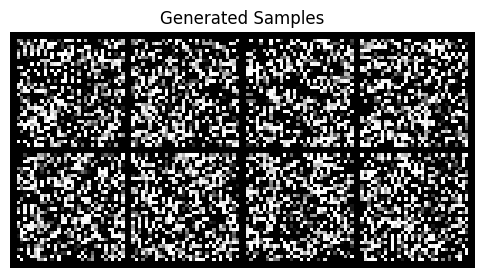

Epoch 0: 100%|██████████| 938/938 [05:22<00:00,  2.91it/s, loss=0.0272]


Epoch 0 | Train Loss: 0.0272 | Val Loss: 0.0156


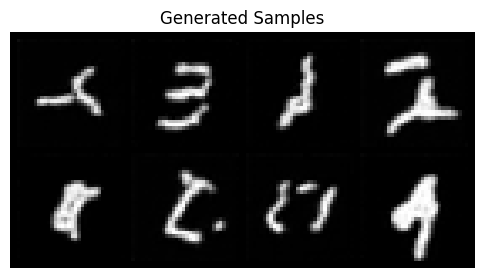

Epoch 1: 100%|██████████| 938/938 [04:00<00:00,  3.91it/s, loss=0.0137]


Epoch 1 | Train Loss: 0.0137 | Val Loss: 0.0127


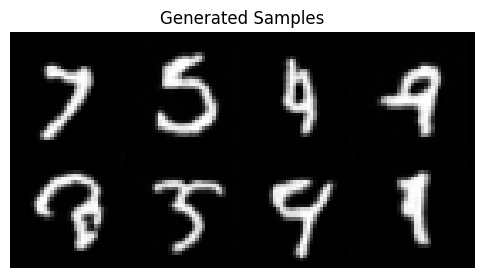

Epoch 2: 100%|██████████| 938/938 [04:00<00:00,  3.89it/s, loss=0.0123]


Epoch 2 | Train Loss: 0.0123 | Val Loss: 0.0118


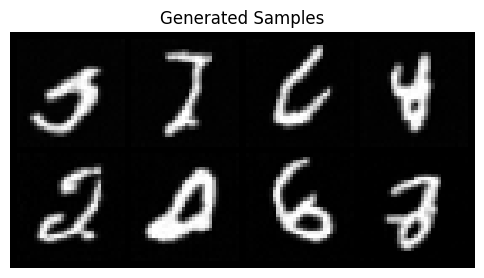

Epoch 3: 100%|██████████| 938/938 [04:01<00:00,  3.89it/s, loss=0.0118]


Epoch 3 | Train Loss: 0.0118 | Val Loss: 0.0110


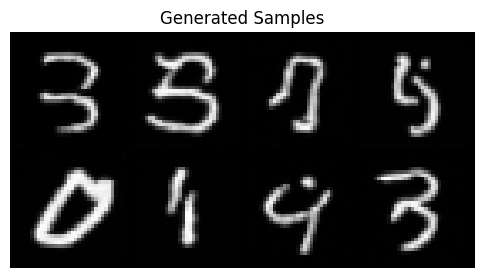

Epoch 4: 100%|██████████| 938/938 [04:01<00:00,  3.89it/s, loss=0.0112]


Epoch 4 | Train Loss: 0.0112 | Val Loss: 0.0111


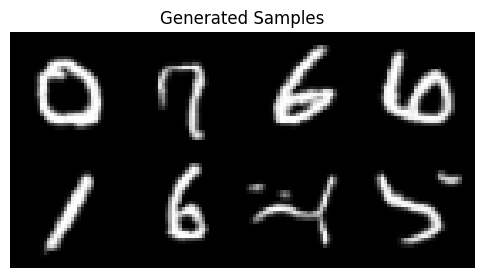

Epoch 5: 100%|██████████| 938/938 [04:02<00:00,  3.87it/s, loss=0.0109]


Epoch 5 | Train Loss: 0.0109 | Val Loss: 0.0108


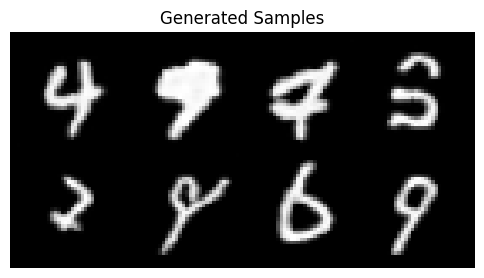

Epoch 6: 100%|██████████| 938/938 [04:01<00:00,  3.88it/s, loss=0.0109]


Epoch 6 | Train Loss: 0.0109 | Val Loss: 0.0108


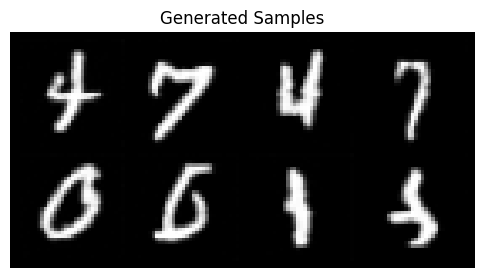

Epoch 7: 100%|██████████| 938/938 [04:01<00:00,  3.89it/s, loss=0.0108]


Epoch 7 | Train Loss: 0.0108 | Val Loss: 0.0108


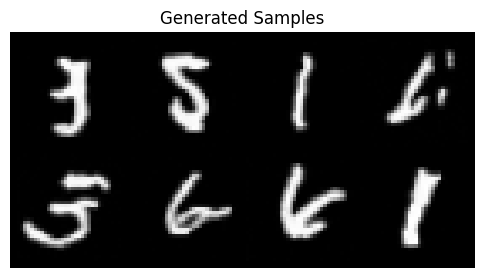

Epoch 8: 100%|██████████| 938/938 [04:01<00:00,  3.88it/s, loss=0.0104]


Epoch 8 | Train Loss: 0.0104 | Val Loss: 0.0107


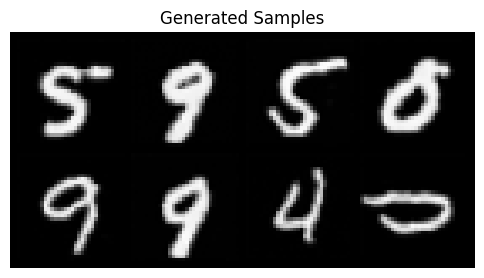

Epoch 9: 100%|██████████| 938/938 [04:01<00:00,  3.88it/s, loss=0.0105]


Epoch 9 | Train Loss: 0.0105 | Val Loss: 0.0109


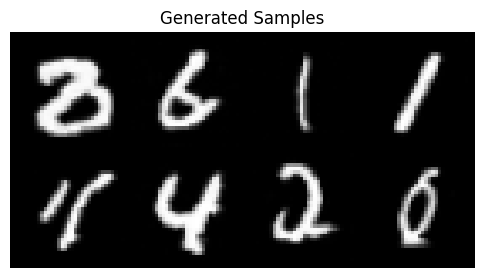

([0.027204137625121104,
  0.01374014526722766,
  0.012297742557265103,
  0.011771395843702435,
  0.01119976859591377,
  0.010925326489412518,
  0.010878165237613514,
  0.01076132169108528,
  0.01039705702216863,
  0.010474025324952087],
 [0.015617880982103621,
  0.01271589191416931,
  0.011763523113290975,
  0.01101563148093736,
  0.01107278218860649,
  0.010773907554970616,
  0.010789865939314388,
  0.010772427716025502,
  0.010654164436658856,
  0.010913316047732618])

In [50]:
train(
    model=model,
    optimizer=torch.optim.Adam(params=model.parameters(), lr=2e-4),
    epochs=10,
    device=device,
    train_dataloader=data.train_loader,
    val_dataloader=data.val_loader
)